In [48]:
import torch 
import torchvision
from torch import nn
from torchvision import transforms
from torch.nn import functional as F
from torch.utils.data import DataLoader

import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from glob import glob

# setting

In [49]:
torch.backends.cudnn.benchmark = True

In [50]:
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

In [51]:
device = 'cuda:0'

In [52]:
style_layer = ['1_1','2_1','3_1','4_1']
content_layer = ['2_1']

In [53]:
image_size = 224
content_weight = 1e1
style_weight = 5e5
lr = 1e-4
epoches = 3
batch_size = 16
acc_iter = 4

In [54]:
transform_x = transforms.Compose([
  transforms.Resize((image_size, image_size)),
#   transforms.CenterCrop((image_size,image_size)),
  transforms.ToTensor()  
])

In [55]:
transform_y = transforms.Compose([
  transforms.Resize((image_size, image_size)),
  transforms.ToTensor()  
])

# dataset

In [56]:
class ImageDataset(torch.utils.data.Dataset):
    
    def __init__(self,root:str,transform=None):
        self.path = glob(root+'*.jpg')
        self.transform = transform
        
    def __len__(self):
#         return 1000
        return len(self.path)
    
    def __getitem__(self,idx):
        pic = Image.open(self.path[idx]).convert('RGB')
        if self.transform: pic = self.transform(pic)
            
        return pic

In [57]:
dataset = ImageDataset('../../../data/VOCdevkit/**/**/', transform_x)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

In [58]:
len(dataset)

27088

# model

In [59]:
class Normalization(nn.Module):
    
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        ## C,1,1 shape for broadcasting
        self.mean = torch.tensor(mean).view(1,-1, 1, 1).to(device)
        self.std = torch.tensor(std).view(1,-1, 1, 1).to(device)

    def forward(self, img):
        # normalize img
        return (img - self.mean)/self.std

In [60]:
class ConvBlock(nn.Module):
    
    def __init__(self, in_c:int, out_c:int, k_size:int, stride:int, 
                post_in: bool = True, relu: bool = True, deconv: bool = False):
        super(ConvBlock, self).__init__()
        self.post_in = post_in
        self.relu = relu
        self.deconv = deconv
        
        self.reflection_pad = nn.ReflectionPad2d(k_size // 2)
        self.conv = nn.Conv2d(in_c, out_c, k_size, stride)            
        if post_in: self.IN = nn.InstanceNorm2d(out_c,affine=True)
        
    def forward(self, x):
        if self.deconv: x = F.interpolate(x, scale_factor=2)
        y = self.reflection_pad(x)
        y = self.conv(y)
        if self.post_in: y = self.IN(y)
        if self.relu: y = F.relu(y)
        return y

In [61]:
class ResidualBlock(nn.Module):
    
    def __init__(self, c:int):
        super(ResidualBlock, self).__init__()
        self.conv1 = ConvBlock(c, c, k_size=3, stride=1)
        self.conv2 = ConvBlock(c, c, k_size=3, stride=1, relu=False)
    
        
    def forward(self, x):
        y = self.conv1(x)
        y = self.conv2(y)
        return x+y

In [62]:
class Generator(nn.Module):
    
    def __init__(self):
        super(Generator, self).__init__()
        # Initial convolution layers
        self.conv1 = ConvBlock(3, 32, k_size=9, stride=1)
        self.conv2 = ConvBlock(32, 64, k_size=3, stride=2)
        self.conv3 = ConvBlock(64, 128, k_size=3, stride=2)
        # Residual layers
        self.res1 = ResidualBlock(128)
        self.res2 = ResidualBlock(128)
        self.res3 = ResidualBlock(128)
        self.res4 = ResidualBlock(128)
        self.res5 = ResidualBlock(128)
        # Upsampling Layers
        self.deconv1 = ConvBlock(128, 64, k_size=3, stride=1,deconv=True)
        self.deconv2 = ConvBlock(64, 32, k_size=3, stride=1,deconv=True)
        self.deconv3 = ConvBlock(32, 3, k_size=9, stride=1,
                                 post_in=False,relu=False)
    
    def forward(self, x):
        y = self.conv1(x)
        y = self.conv2(y)
        y = self.conv3(y)
        y = self.res1(y)
        y = self.res2(y)
        y = self.res3(y)
        y = self.res4(y)
        y = self.res5(y)
        y = self.deconv1(y)
        y = self.deconv2(y)
        y = self.deconv3(y)
#         y = y.tanh()
        return y

In [63]:
class FeatureNetwork(nn.Module):
    
    def __init__(self, cnn: nn.Module):
        super(FeatureNetwork, self).__init__()
        self.feature_extractor = cnn
    
    def forward(self, img, mode:str):
        block_num, conv_num = 0, 0
        conv_list = []
        
        for l in self.feature_extractor:
            img = l(img)
            if isinstance(l, nn.ReLU):
                conv_num += 1
                layer_name = f'{block_num+1}_{conv_num}'
                if layer_name in content_layer and mode=='content':
                    conv_list = [img]
                    break
                if layer_name in style_layer and mode=='style':
                    conv_list.append(img)
            elif isinstance(l, nn.MaxPool2d):
                block_num += 1
                conv_num = 0

        return conv_list

In [64]:
class CustomLoss(nn.Module):
    
    def __init__(self):
        super(CustomLoss, self).__init__()
    
    @staticmethod
    def gram_matrix(x: torch.Tensor) -> torch.Tensor:
        a, b, c, d = x.shape
        y = x.reshape(a, b, c*d)
        y = torch.bmm(y, y.transpose(1, 2))
        y = y / (b*c*d)
        
        return y
    
    def calc_style_loss(self, generated_feature, style_gram):
        generated_gram = self.gram_matrix(generated_feature)
        return F.mse_loss(generated_gram, style_gram)
    
    def calc_content_loss(self, generated_feature, content_feature):
        return F.mse_loss(generated_feature, content_feature)
        
    def forward(self, 
                content_feature: torch.Tensor, 
                style_grams: list[torch.Tensor], 
                generated_features: list[torch.Tensor],
        ):
        content_loss = 0
        style_loss = 0
        
        for generated_feature, style_gram in zip(generated_features, style_grams): 
            style_loss += self.calc_style_loss(generated_feature, style_gram)

        content_loss += self.calc_content_loss(
            generated_features[style_layer.index(content_layer[0])], 
            content_feature,
        )
                
        return content_loss, style_loss

In [65]:
cnn = torchvision.models.vgg16(weights='DEFAULT').features.to(device).eval()

In [66]:
feature_extractor = FeatureNetwork(cnn)

In [67]:
generator = Generator().to(device)

In [68]:
normalization = Normalization(IMAGENET_MEAN, IMAGENET_STD)

# start transfer

In [69]:
style_img = transform_y(Image.open('../../../data/styles/starry.jpg')).repeat(batch_size, 1, 1, 1).to(device)
style_img = normalization(style_img)

with torch.no_grad():
    style_features = feature_extractor(style_img, mode='style')
    style_grams = [
        CustomLoss.gram_matrix(style_feature) 
        for style_feature in style_features
    ]

In [70]:
criterion = CustomLoss()
optimizer = torch.optim.Adam(generator.parameters(), lr=lr)

In [71]:
for e in range(epoches):
    c_score, s_score = 0, 0
    acc_iter = 0
    optimizer.zero_grad()
    generator.train()

    for img in tqdm(dataloader):
        acc_iter += 1
        img = img.to(device)
        img = normalization(img)
        gen_img = generator(img)
        
        with torch.no_grad():
            content_feature = feature_extractor(img, mode='content')[0]
        generated_features = feature_extractor(gen_img, mode='style')

        content_loss, style_loss = criterion(content_feature, style_grams, generated_features)
        loss = content_weight * content_loss + style_weight * style_loss
        loss = loss / acc_iter
        loss.backward()
        
        # gradient accumulation
        if acc_iter % acc_iter == 0 :
            optimizer.step()
            optimizer.zero_grad()
        
        c_score += content_loss.item()
        s_score += style_loss.item()
        
    print(f'epoch: {e+1}, content loss: {c_score / len(dataset)}, style loss: {s_score / len(dataset)}')

100%|██████████| 1693/1693 [07:21<00:00,  3.84it/s]


epoch: 1, content loss: 0.22648349326000505, style loss: 5.394273670023872e-06


100%|██████████| 1693/1693 [07:08<00:00,  3.95it/s]


epoch: 2, content loss: 0.2229764689039494, style loss: 2.57918404106518e-06


100%|██████████| 1693/1693 [07:07<00:00,  3.96it/s]

epoch: 3, content loss: 0.20938899361446492, style loss: 1.8257609350785092e-06


In [92]:
torch.save(generator, f'style.{content_weight:.0e}.{style_weight:.0e}.pth')

In [73]:
# torch.onnx.export(feature_extractor,torch.rand(1,3,224,224).cuda(),'a.onnx')

In [74]:
# generator = torch.load('style.pth').to(device)

# visualize

In [82]:
def tensor_to_np(tensor):
    return tensor.permute(1,2,0).squeeze(0).detach().cpu().numpy() 

In [83]:
def raw_image_load(path:str) -> torch.Tensor:
    return transforms.ToTensor()(Image.open(path)).to(device)

In [84]:
def denormalization(x: torch.Tensor, mean: torch.Tensor, std: torch.Tensor) -> torch.Tensor:
    return mean + std * x 

In [85]:
content_img = raw_image_load('../../../data/contents/101.jpg')
style_img = raw_image_load('../../../data/styles/starry.jpg')

generator.eval()
with torch.no_grad():
    output = generator(normalization(content_img.unsqueeze(0)))
    output = tensor_to_np(output.squeeze(0))
    output = denormalization(output, IMAGENET_MEAN, IMAGENET_STD).clip(0, 1)

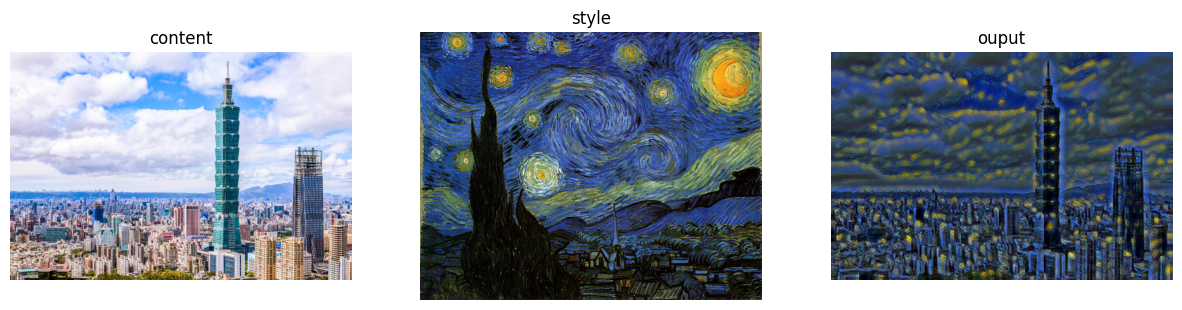

In [86]:
plt.figure(figsize=(15,25))
plt.subplot(1,3,1)
plt.title('content')
plt.axis('off')
plt.imshow(tensor_to_np(content_img))
plt.subplot(1,3,2)
plt.title('style')
plt.axis('off')
plt.imshow(tensor_to_np(style_img))
plt.subplot(1,3,3)
plt.title('ouput')
plt.axis('off')
plt.imshow(output)

In [80]:
cv2.imwrite('output.jpg', (output[:,:,::-1] * 255).astype(np.uint8).clip(0, 255))

True

# video

In [93]:
generator = torch.load('artifacts/sketch.pth').to(device)

In [94]:
vid = cv2.VideoCapture('artifacts/cat.mp4')

num_frame = int(vid.get(cv2.CAP_PROP_FRAME_COUNT))
frame_h = int(vid.get(cv2.CAP_PROP_FRAME_HEIGHT))
frame_w = int(vid.get(cv2.CAP_PROP_FRAME_WIDTH))
fps = vid.get(5)

fourcc = cv2.VideoWriter_fourcc(*'XVID')
vid_writer = cv2.VideoWriter('output.avi', fourcc, fps, (frame_w, frame_h//2))

In [95]:
# placeholder = []
for i in tqdm(range(num_frame)):
    ret, frame = vid.read()
    if not ret: break
    
    frame = cv2.resize(frame, (frame_w//2, frame_h//2))

    frame = frame.astype(np.float32)
    frame = frame / 255
    # placeholder.append(frame)
    
    # if len(placeholder) == 2:
    # batch_frame = np.stack(placeholder)    
    batch_frame = torch.from_numpy(frame).unsqueeze_(0).permute(0,3,1,2).to(device)
    batch_frame = normalization(batch_frame)

    generator.eval()
    with torch.no_grad():
        output = generator(batch_frame)
        output = output.permute(0,2,3,1).clamp(0, 1).detach().cpu().numpy()

    # release memory
    # batch_frame = batch_frame.permute(0,2,3,1).detach().cpu().numpy()

    compare_list = np.concatenate([np.expand_dims(frame, 0), output], axis=2) * 255
    # for compare in compare_list: 
    vid_writer.write(compare_list[0].astype(np.uint8).clip(0, 255))
    # if i == 1000: break

100%|██████████| 2936/2936 [01:18<00:00, 37.39it/s]


In [96]:
vid_writer.release()
vid.release()